# VAE for Bitcoin  

I am interested in extracting structural moifs from timeseries. Here, I am going to investigate using a variational autoencoder for this. I will build the model and then spend some time trying to understand which parts of the timeseries activate the model the most (these must be the important parts...).  


In [1]:
library(ggplot2)
library(data.table)
library(keras)
install_keras()

data_file_pattern <- "../Data/%s/poloniex/PoloniexChartData_USDT_BTC.csv"
raw_data <- rbindlist(
    lapply(2015:2018, function (yr) {
        tmp <- fread(sprintf(data_file_pattern, yr))
        tmp[, Datestamp := as.POSIXct(Datestamp)]
        tmp[, HourlyStamp := as.POSIXct(strftime(Datestamp, format = "%Y-%m-%d %H:00:00"))]
        tmp[, DailyStamp := as.POSIXct(strftime(Datestamp, format = "%Y-%m-%d"))]
        tmp[, HourlyMaxClose := max(close), by = "HourlyStamp"]
        return(tmp)
    })
)

str(raw_data)
head(raw_data[order(date, decreasing = FALSE)], n = 10)

Creating virtualenv for TensorFlow at  ~/.virtualenvs/r-tensorflow 
Installing TensorFlow ...

Installation complete.

Classes ‘data.table’ and 'data.frame':	119106 obs. of  12 variables:
 $ close          : num  225 225 225 225 225 240 240 244 244 244 ...
 $ date           : int  1424372400 1424373300 1424374200 1424375100 1424376000 1424376900 1424377800 1424378700 1424379600 1424380500 ...
 $ high           : num  225 225 225 225 225 240 240 244 244 244 ...
 $ low            : num  225 225 225 225 225 225 240 244 244 244 ...
 $ open           : num  225 225 225 225 225 225 240 244 244 244 ...
 $ quoteVolume    : num  0.00444 0 0 0 0 ...
 $ volume         : num  1 0 0 0 0 ...
 $ weightedAverage: num  225 225 225 225 225 ...
 $ Datestamp      : POSIXct, format: "2015-02-19 19:00:00" "2015-02-19 19:15:00" ...
 $ HourlyStamp    : POSIXct, format: "2015-02-19 19:00:00" "2015-02-19 19:00:00" ...
 $ DailyStamp     : POSIXct, format: "2015-02-19" "2015-02-19" ...
 $ HourlyMaxClose : num  22

close,date,high,low,open,quoteVolume,volume,weightedAverage,Datestamp,HourlyStamp,DailyStamp,HourlyMaxClose
225,1424372400,225,225,225,0.00444444,0.999999,225.0000,2015-02-19 19:00:00,2015-02-19 19:00:00,2015-02-19,225
225,1424373300,225,225,225,0.00000000,0.000000,225.0000,2015-02-19 19:15:00,2015-02-19 19:00:00,2015-02-19,225
225,1424374200,225,225,225,0.00000000,0.000000,225.0000,2015-02-19 19:30:00,2015-02-19 19:00:00,2015-02-19,225
225,1424375100,225,225,225,0.00000000,0.000000,225.0000,2015-02-19 19:45:00,2015-02-19 19:00:00,2015-02-19,225
225,1424376000,225,225,225,0.00000000,0.000000,225.0000,2015-02-19 20:00:00,2015-02-19 20:00:00,2015-02-19,244
240,1424376900,240,225,225,0.12862524,30.624650,238.0921,2015-02-19 20:15:00,2015-02-19 20:00:00,2015-02-19,244
240,1424377800,240,240,240,0.00000000,0.000000,240.0000,2015-02-19 20:30:00,2015-02-19 20:00:00,2015-02-19,244
244,1424378700,244,244,244,0.06004601,14.651226,244.0000,2015-02-19 20:45:00,2015-02-19 20:00:00,2015-02-19,244
244,1424379600,244,244,244,0.00000000,0.000000,244.0000,2015-02-19 21:00:00,2015-02-19 21:00:00,2015-02-19,244
244,1424380500,244,244,244,0.00000000,0.000000,244.0000,2015-02-19 21:15:00,2015-02-19 21:00:00,2015-02-19,244


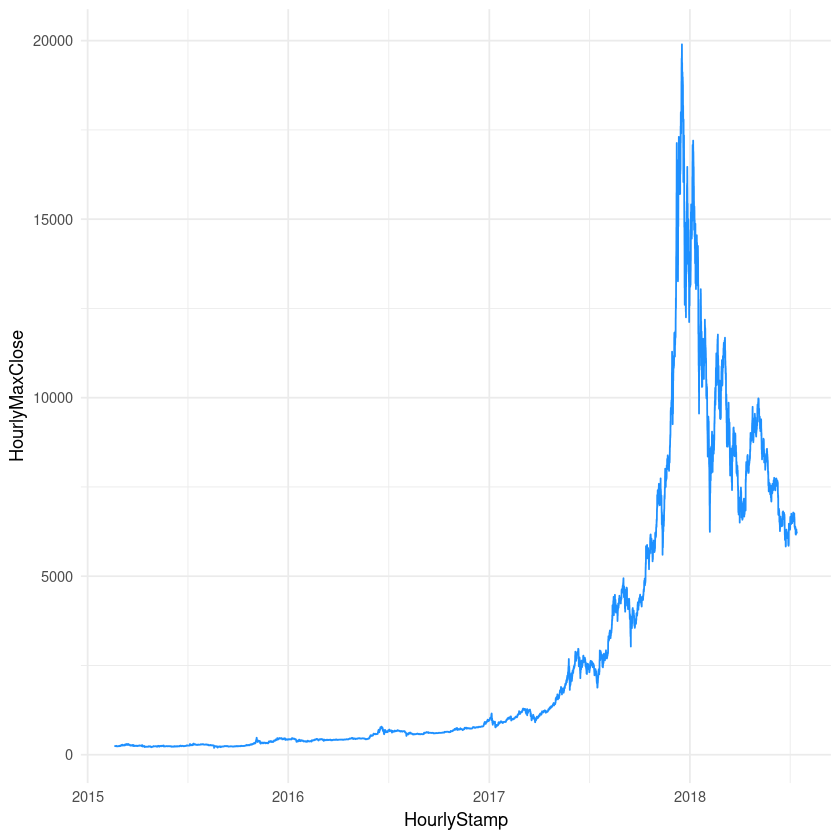

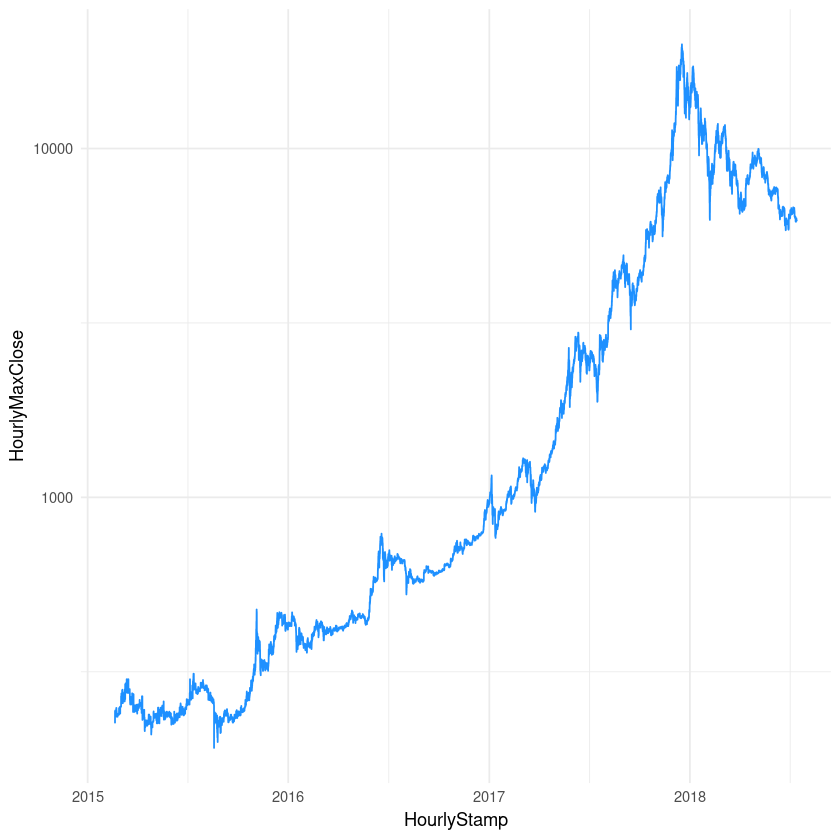

In [2]:
g <- ggplot(raw_data, aes(x = HourlyStamp, y = HourlyMaxClose)) +
    geom_line(colour = "dodgerblue") +
    theme_minimal()

print(g)
print(g + scale_y_log10())

I am going to work with 3 week windows. Below, I have created a generator function which extracts the closing price in 3 week blocks:

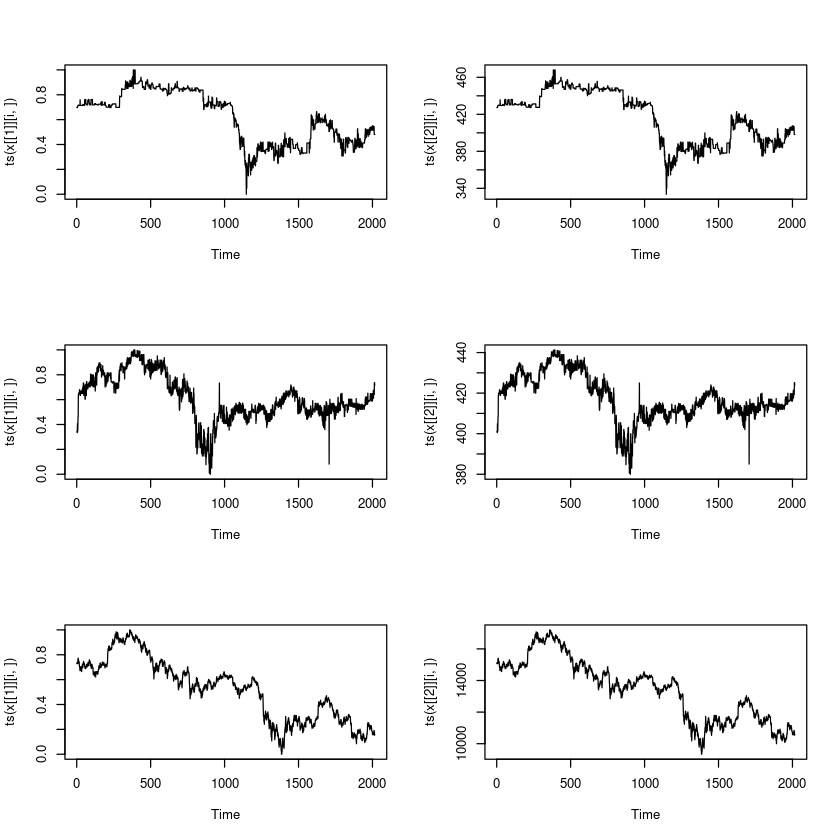

In [3]:
get_window <- function (input_data, period = 3, batch_size = 64) {
    
    
    function () {
        
        xs <- sample(nrow(input_data), batch_size, replace = TRUE)
        dimensions <- (4 * 24 * 7 * period)
        
        original <- matrix(0, nrow = batch_size, ncol = dimensions)
        sequences <- matrix(0, nrow = batch_size, ncol = dimensions)
        
        for (x in 1:length(xs)) {
            start_ <- input_data[xs[x], Datestamp]
            end_ <- start_ + (period * 7 * 24 * 60 * 60)
            
            z <- input_data[Datestamp >= start_ & Datestamp <= end_, close]
            original[x, ] <- z[1:dimensions]
            z <- (z - min(z)) / (max(z) - min(z))
            
            # Pad with trailing zeros if necessary
            if (length(z) < dimensions) {
                z_ <- rep(0, dimensions)
                z_[1:length(z)] <- z
                
                z <- z_
            }

            sequences[x, ] <- z[1:dimensions]
        }
        return (list(sequences, original))
    }
}
factory <- get_window(raw_data)
x <- factory()
par(mfrow=c(3, 2))
for (i in 1:3) {
    plot(ts(x[[1]][i, ]))
    plot(ts(x[[2]][i, ]))
}
par(mfrow = c(1, 1))

That looks like it is working. Let's now setup the model...

In [5]:
factory <- get_window(raw_data)
period <- 4
original_dim <- 2016
latent_dim <- 16L
intermediate_dim <- 512L
epochs <- 50L
epsilon_std <- 1.0

# Model definition --------------------------------------------------------

x <- layer_input(shape = c(original_dim))
h <- layer_dense(x, intermediate_dim, activation = "relu")
z_mean <- layer_dense(h, latent_dim)
z_log_var <- layer_dense(h, latent_dim)

sampling <- function(arg){
  z_mean <- arg[, 1:(latent_dim)]
  z_log_var <- arg[, (latent_dim + 1):(2 * latent_dim)]
  
  epsilon <- k_random_normal(
    shape = c(k_shape(z_mean)[[1]]), 
    mean=0.,
    stddev=epsilon_std
  )
  
  z_mean + k_exp(z_log_var/2)*epsilon
}

# note that "output_shape" isn't necessary with the TensorFlow backend
z <- layer_concatenate(list(z_mean, z_log_var)) %>% 
  layer_lambda(sampling)

# we instantiate these layers separately so as to reuse them later
decoder_h <- layer_dense(units = intermediate_dim, activation = "relu")
decoder_mean <- layer_dense(units = original_dim, activation = "sigmoid")
h_decoded <- decoder_h(z)
x_decoded_mean <- decoder_mean(h_decoded)

# end-to-end autoencoder
vae <- keras_model(x, x_decoded_mean)

# encoder, from inputs to latent space
encoder <- keras_model(x, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input <- layer_input(shape = latent_dim)
h_decoded_2 <- decoder_h(decoder_input)
x_decoded_mean_2 <- decoder_mean(h_decoded_2)
generator <- keras_model(decoder_input, x_decoded_mean_2)


vae_loss <- function(x, x_decoded_mean){
  xent_loss <- (original_dim/1.0)*loss_binary_crossentropy(x, x_decoded_mean)
  kl_loss <- -0.5*k_mean(1 + z_log_var - k_square(z_mean) - k_exp(z_log_var), axis = -1L)
  xent_loss + kl_loss
}

vae %>% compile(optimizer = "rmsprop", loss = vae_loss)

In [6]:
x_train <- do.call(rbind, lapply(1:200, function (x) factory()[[1]]))
x_test <- do.call(rbind, lapply(1:10, function (x) factory()[[1]]))

dim(x_train)
dim(x_test)

[1] 12800  2016

[1]  640 2016

In [ ]:
vae %>% fit(
  x_train, x_train, 
  shuffle = TRUE, 
  epochs = epochs, 
  batch_size = 32, 
  validation_data = list(x_test, x_test)
)

Now, let's try to visualise the results...

In [12]:
results <- predict(encoder, x_test, batch_size = 128) 
dim(results)

[1] 640   8

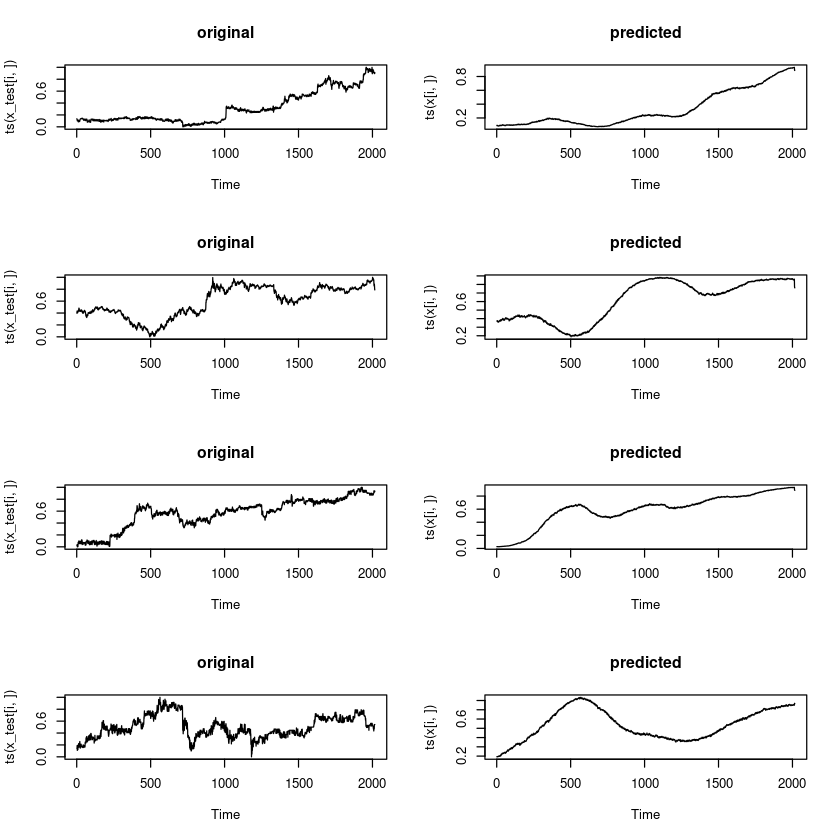

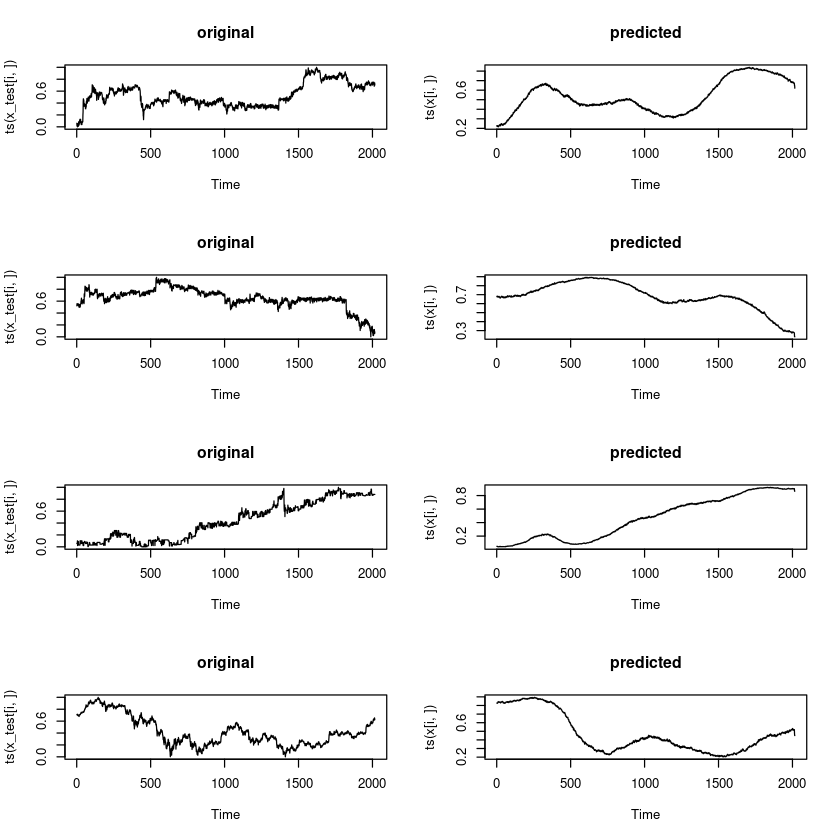

In [13]:
x<-predict(generator, results)

par(mfrow = c(4, 2))
for (i in sample(640, 8)) {
    plot(ts(x_test[i, ]), main = "original")
    plot(ts(x[i, ]), main = "predicted")
} 
par(mfrow = c(1, 1))